In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adamax
from keras.losses import MeanSquaredError
from keras.activations import relu
import os
sns.set()
from keras.utils import plot_model


In [2]:
df = yf.download('TSLA','2010-06-29','2019-05-28',interval='1d')     # download the dataset from yahoo services

[*********************100%***********************]  1 of 1 completed


In [3]:
df.shape

(2242, 6)

In [4]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500
...,...,...,...,...,...,...
2019-05-20,13.520000,13.733333,13.016667,13.690667,13.690667,307893000
2019-05-21,13.184000,13.826667,13.069333,13.672000,13.672000,270058500
2019-05-22,13.273333,13.596000,12.785333,12.848667,12.848667,280278000


In [5]:
df = df['Open'].values
print("Total No. of days of TSLA's Stocks :",df.shape[0])

Total No. of days of TSLA's Stocks : 2242


In [6]:
pd.DataFrame(df)

,0
0,1.266667
1,1.719333
2,1.666667
3,1.533333
4,1.333333
...,...
2237,13.520000
2238,13.184000
2239,13.273333
2240,12.956000


In [7]:
2242- (len(df[:int(df.shape[0]*0.8 )]) )

449

In [8]:
dataset_train = np.array(df[:int(df.shape[0]*0.8)])           ### Split the data into train and test sets considering overlapping (50 days )
dataset_test = np.array(df[int(df.shape[0]*0.8)-50:])
print('Training stock :',dataset_train.shape[0],'days')
print('Test stock :',dataset_test.shape[0],'days')

Training stock : 1793 days
Test stock : 499 days


In [9]:
len(dataset_train) + len (dataset_test)

2292

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train.reshape(-1, 1))
dataset_test = scaler.transform(dataset_test.reshape(-1, 1))

In [11]:
def create_dataset(df,n):   # n is the prediction interval   50   50    0 --->50 , 1---->51  , 2----->52
    x = []
    y = []
    for i in range(n, df.shape[0]):
        x.append(df[i-n:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [21]:
x_train, y_train = create_dataset(dataset_train,50)
x_test, y_test = create_dataset(dataset_test,50)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [22]:
print('Training data shape',x_train.shape)
print('Test data shape',x_test.shape)

Training data shape (1743, 50, 1)
Test data shape (449, 50, 1)


In [ ]:
x_train.shape[1]  ### Number of features in the data set used by the model

50

In [23]:
### LSTM Model for stock prediction
model = Sequential()
model.add(LSTM(units=96,return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96, return_sequences=True))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
### O/P Layer (Full connected part)
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 96)              │          37,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50, 96)              │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 96)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50, 96)              │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 96)                  │          74,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              97 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 260,065 (1015.88 KB)

 Trainable params: 260,065 (1015.88 KB)

 Non-trainable params: 0 (0.00 B)

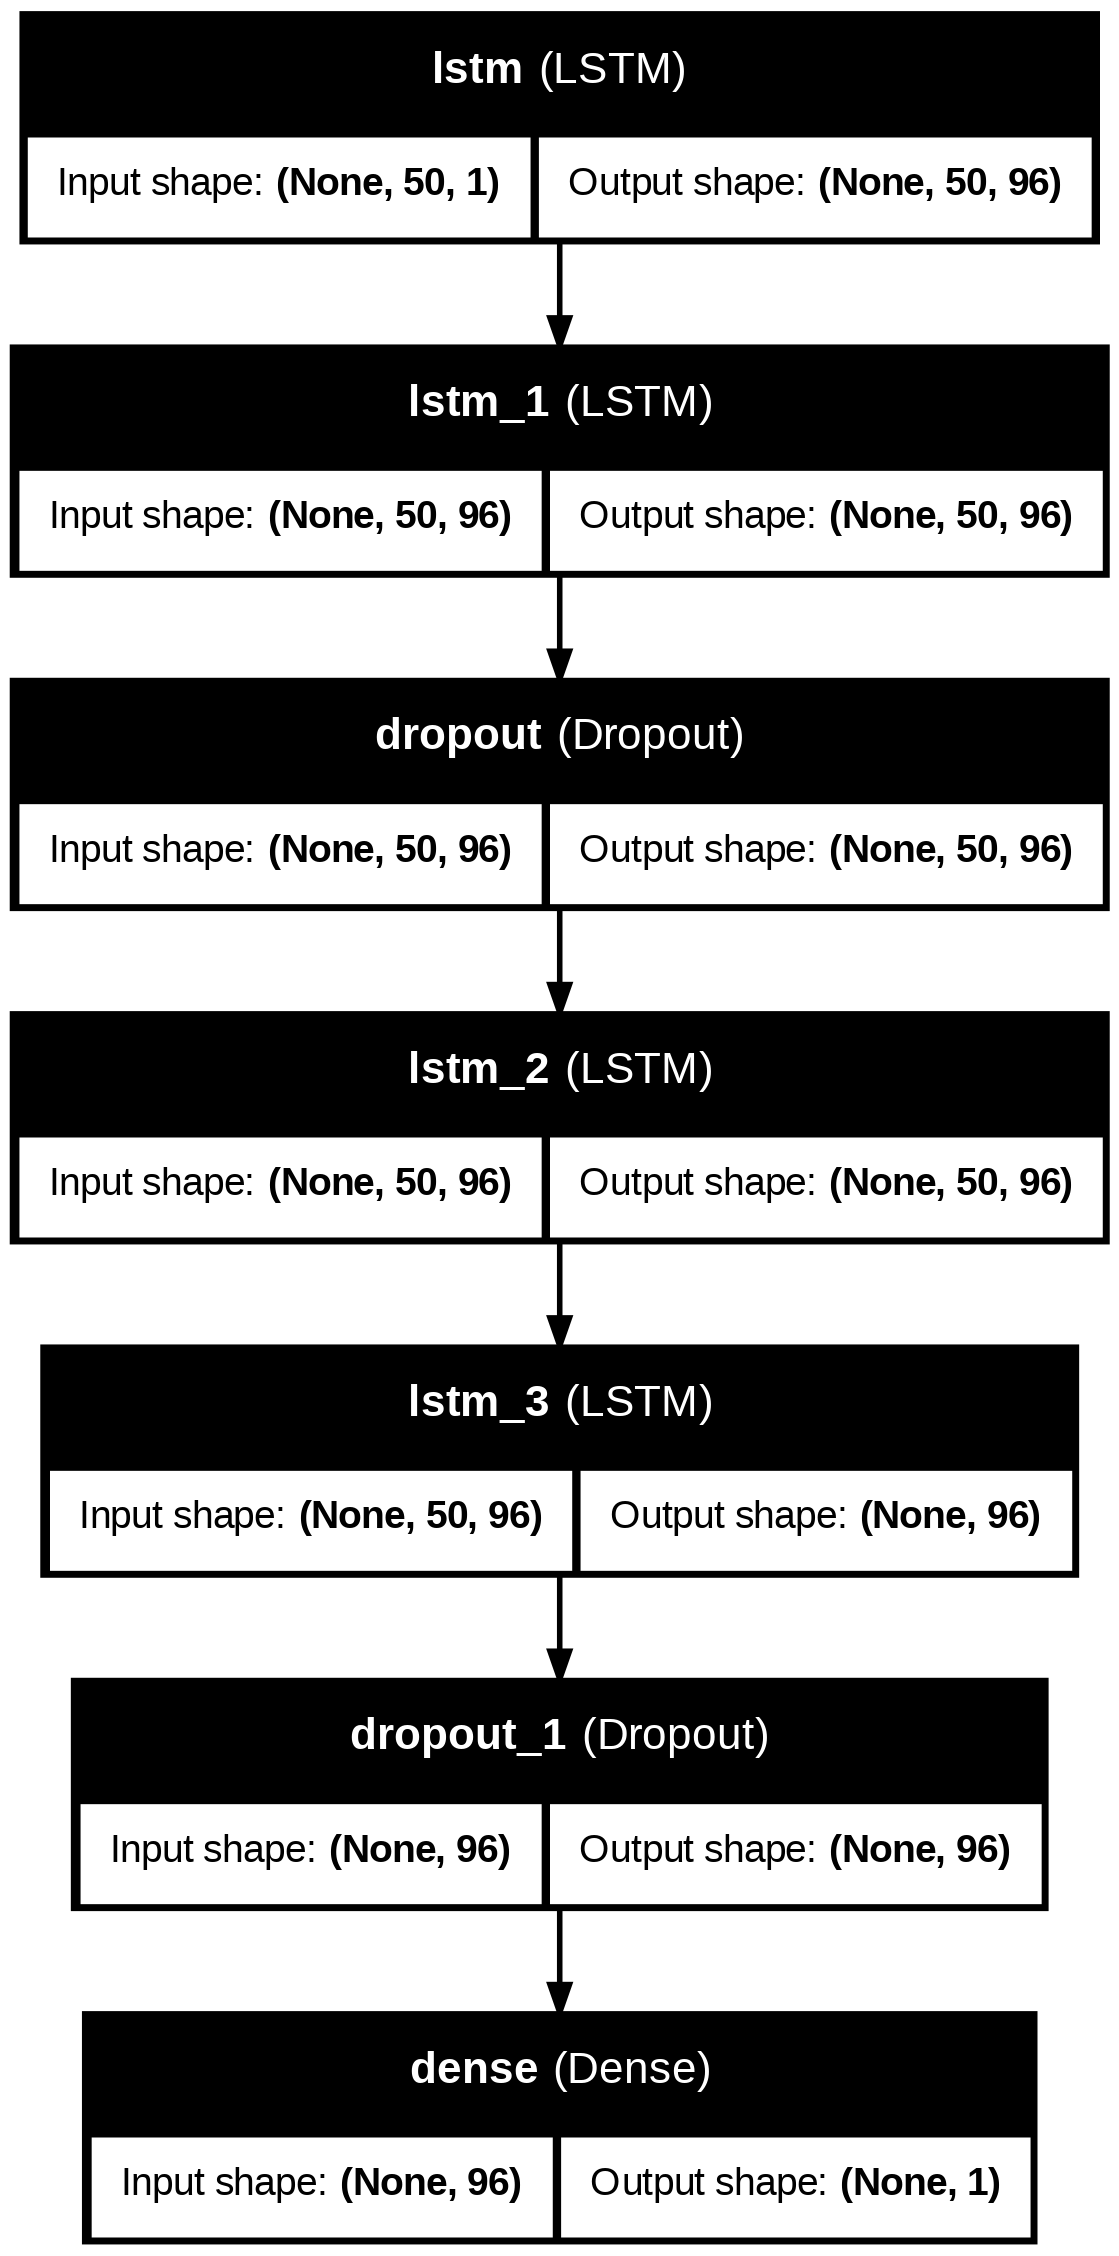

In [24]:
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [25]:
model.compile(loss=MeanSquaredError, optimizer=Adamax(0.001))

In [26]:
history = model.fit(x_train,y_train,batch_size=32,epochs=70,verbose=1,validation_split=0.05)

Epoch 1/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - loss: 0.0359 - val_loss: 0.0094
Epoch 2/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - loss: 0.0028 - val_loss: 0.0062
Epoch 3/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - loss: 0.0026 - val_loss: 0.0061
Epoch 4/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 162ms/step - loss: 0.0021 - val_loss: 0.0101
Epoch 5/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 0.0025 - val_loss: 0.0076
Epoch 6/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 132ms/step - loss: 0.0024 - val_loss: 0.0118
Epoch 7/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - loss: 0.0023 - val_loss: 0.0074
Epoch 8/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 167ms/step - loss: 0.0022 - val_loss: 0.0135
Epoch 9/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - loss: 0.0021 - val_loss: 0.0163
Epoch 10/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 13s 176ms/step - loss: 0.0021 - val_loss: 0.0133
Epoch 11/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 11s 188ms/step - loss: 0.0023 - val_loss: 0.0135
Epoch 12/70
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 131

15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step


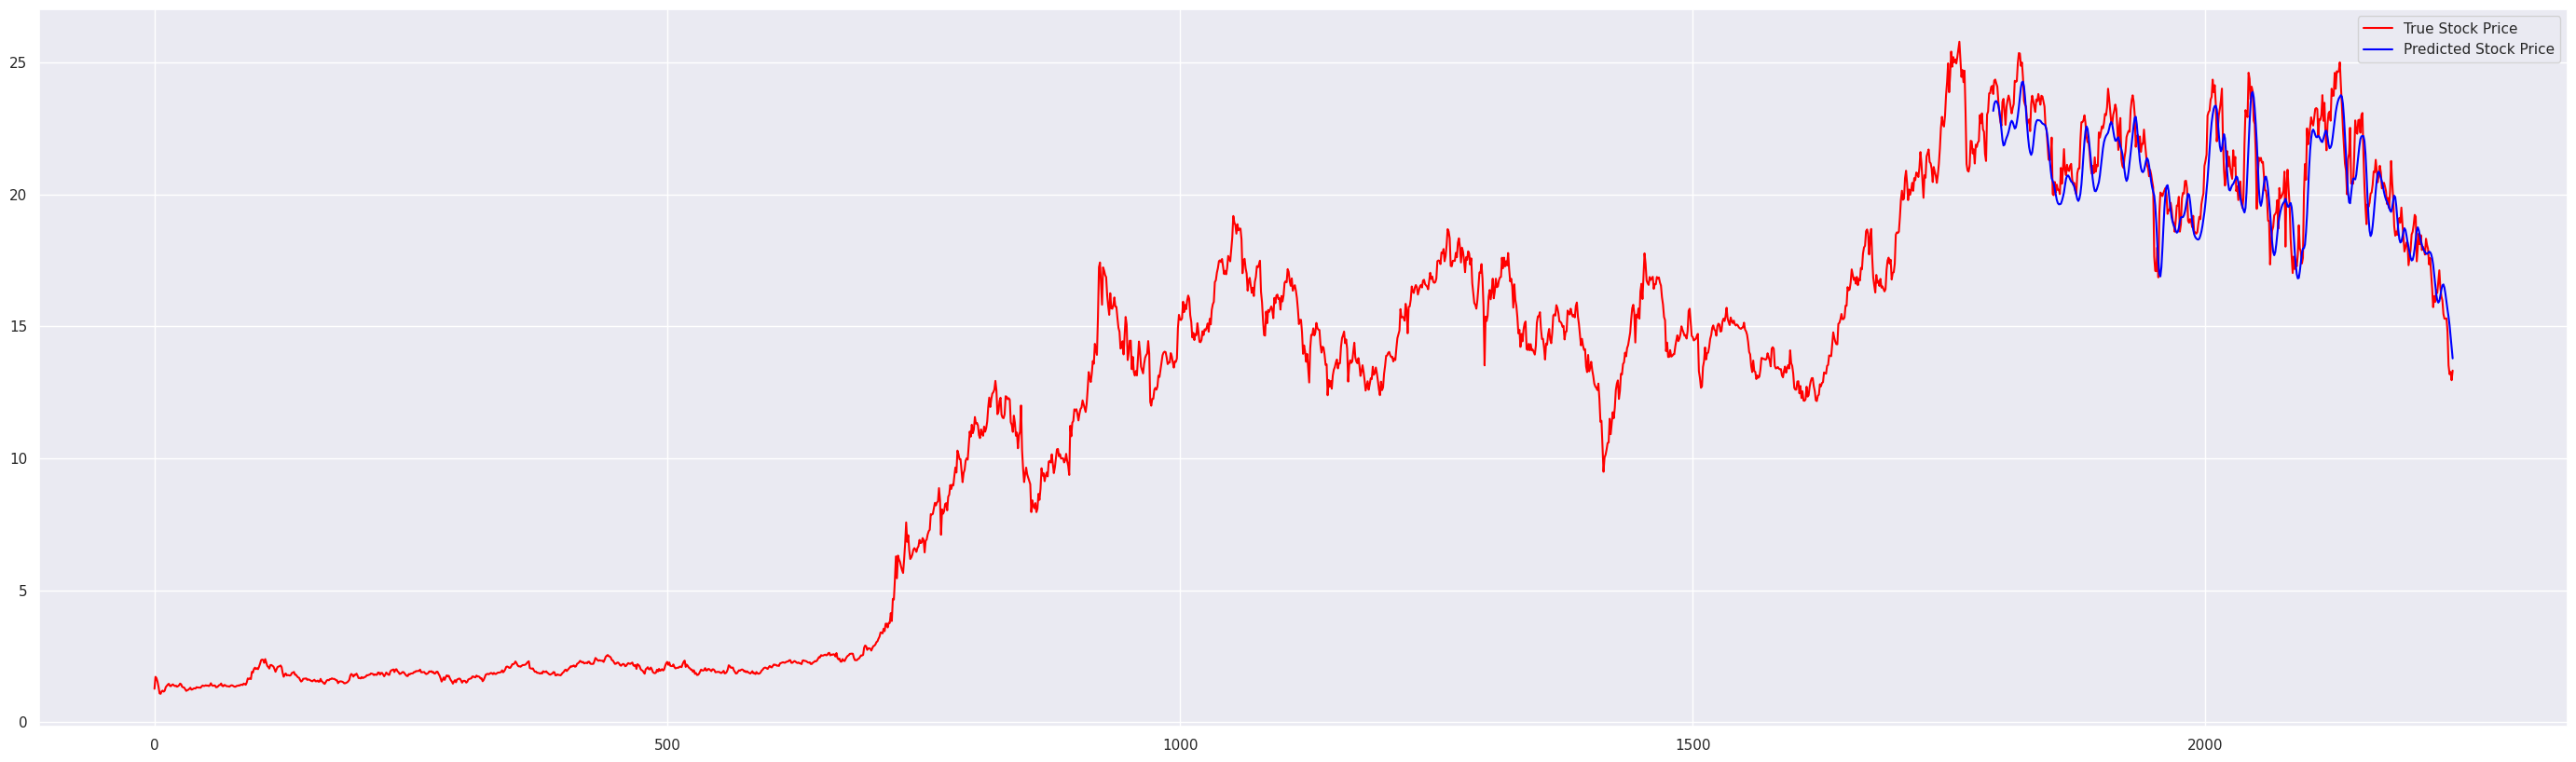

In [27]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
fig, ax = plt.subplots(figsize=(35,10))
plt.plot(df, color='red',  label="True Stock Price",)
ax.plot(range(len(y_train)+50,len(y_train)+50+len(predictions)),predictions, color='blue', label='Predicted Stock Price')
plt.legend()

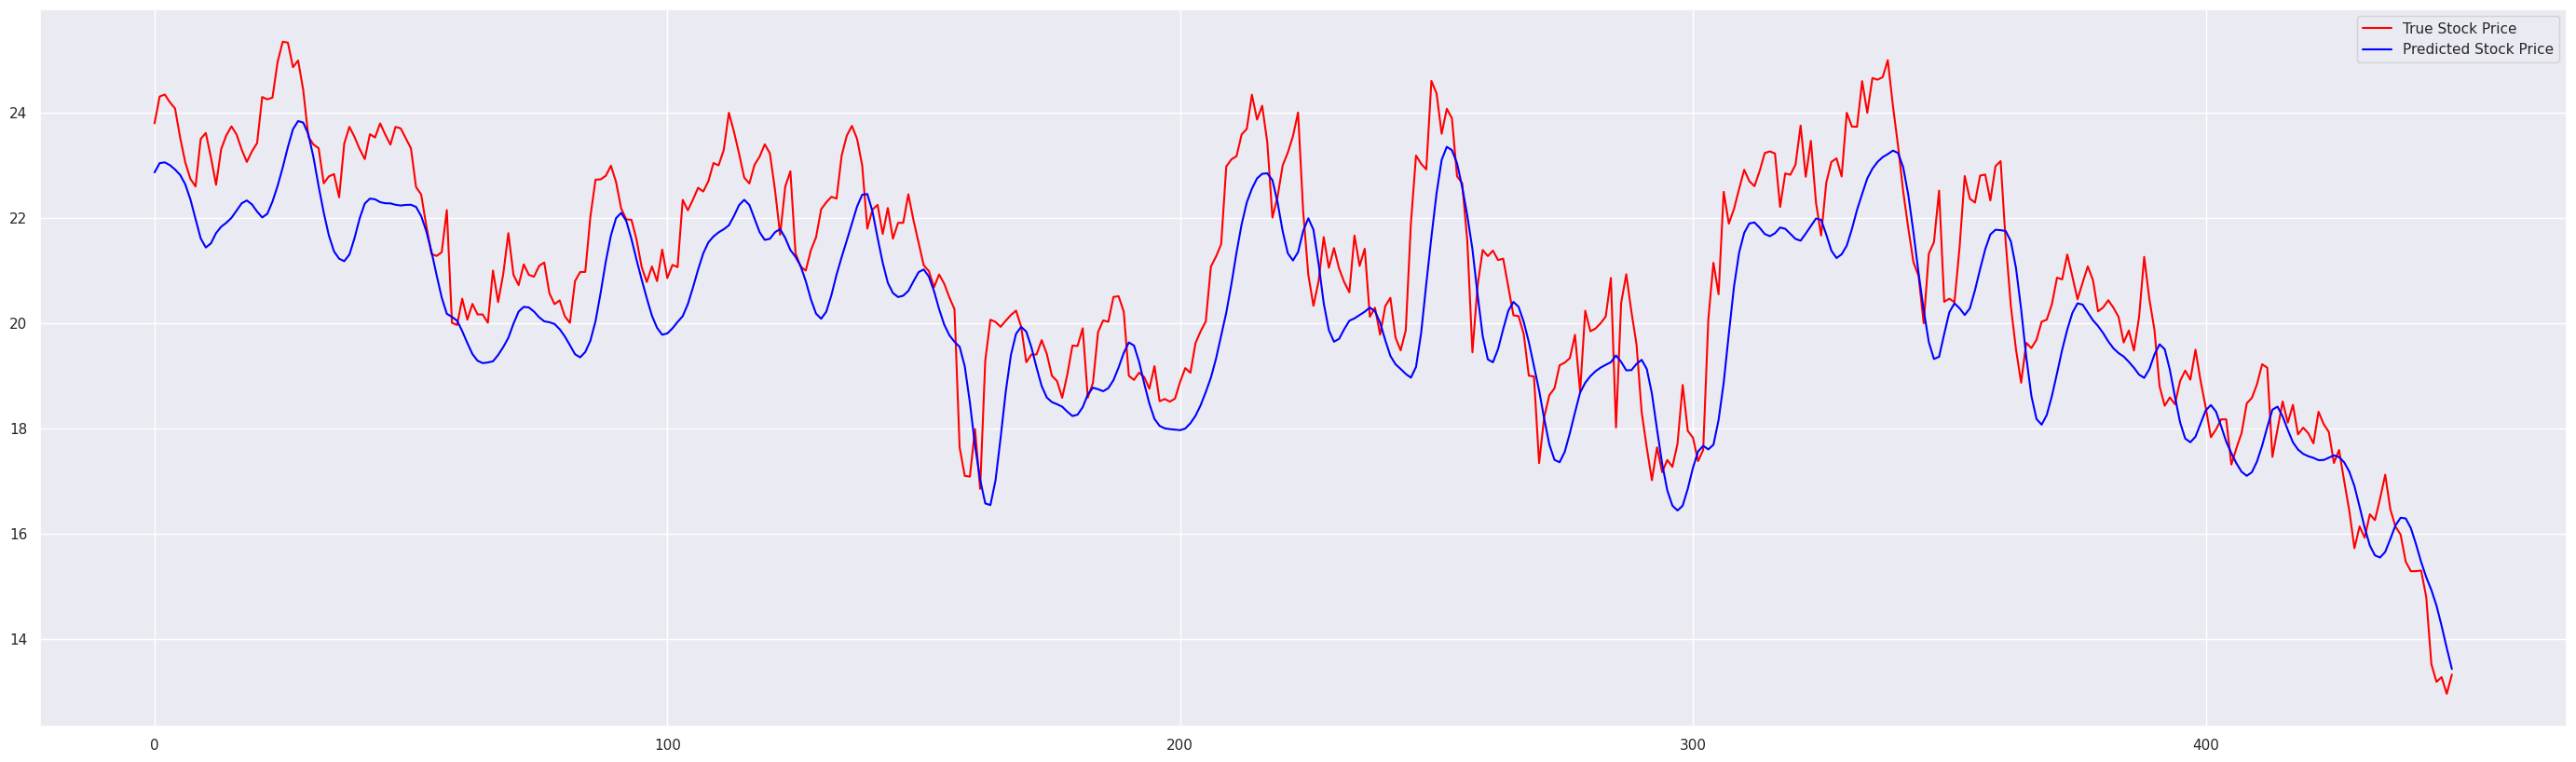

In [ ]:
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
fig, ax = plt.subplots(figsize=(35,10))
ax.plot(y_test_scaled, color='red', label='True Stock Price')
plt.plot(predictions, color='blue', label='Predicted Stock Price')
plt.legend()